# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: 44
* Students: Yann Morize, Diego Debruyn, Silvan Stettler, Nikolai Orgland
* Dataset: Swiss National Council

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
import networkx as nx
import pygsp as pg
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
# Load adjacency
adjacency = np.load('adjacency.npy')
# Make networkx graph
graph = nx.from_numpy_array(adjacency)
laplacian = nx.normalized_laplacian_matrix(graph)

# Load node labels (-1 for left wing, 1 for right wing)
labels = np.load('clustering.npy')
n_nodes = labels.shape[0]
E = np.sum(adjacency>0)  # number of edges (non-zero entries of A)

k_i = np.sum(adjacency, axis=1)
D=np.diag(k_i)

**Gradient calculation**

In [4]:
#Computing the gradient

gradient = np.zeros((E, n_nodes))
eij = 0  # edge index
for i in range(n_nodes):
    for j in range(n_nodes):
        wij = adjacency[i, j]
        if wij > 0:
            gradient[eij,i]=-np.sqrt(wij)/np.sqrt(D[i,i])
            gradient[eij,j]=np.sqrt(wij)/np.sqrt(D[j,j])
            eij = eij + 1  # increment the edge index 

In [5]:
#Test if the gradient has been computed correctly
np.testing.assert_allclose(0.5*(gradient.T @ gradient), laplacian.toarray())

**Some plots of our network**

In [6]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=3,which='SM')

C:\Users\silus\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Normalized laplacian eigenmap')

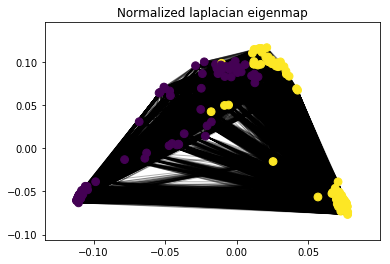

In [7]:
signal = labels
coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title('Normalized laplacian eigenmap')

Text(0.5, 1.0, 'Normalized laplacian eigenmap')

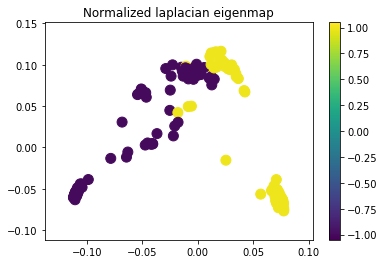

In [8]:
graph_pygsp = pg.graphs.Graph(adjacency)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(signal)
plt.title('Normalized laplacian eigenmap')

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [9]:
vals, vecs = np.linalg.eigh(laplacian.toarray())
e = vals
U = vecs

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

Text(0.5, 1.0, 'Last Fourier basis vector')

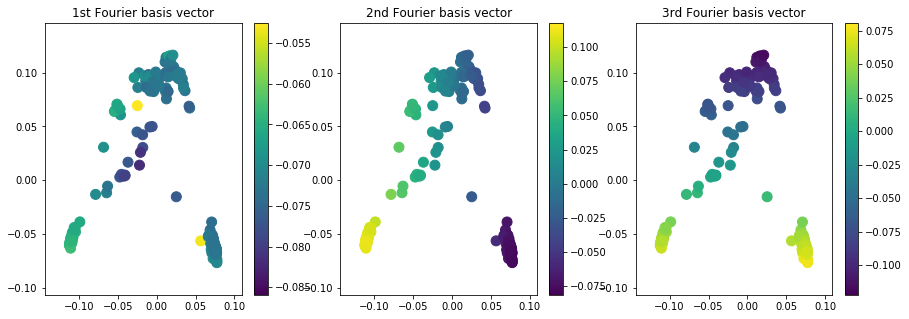

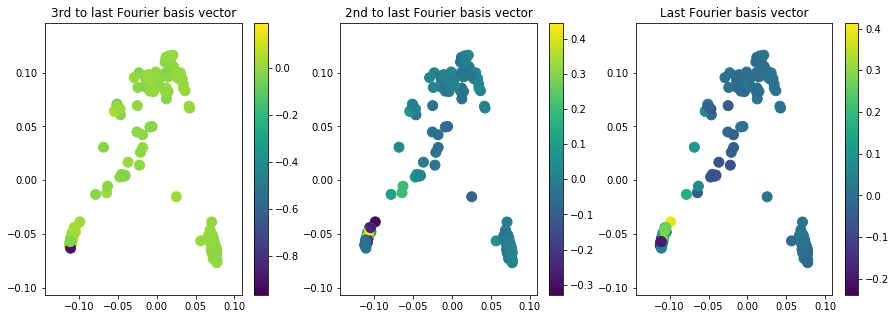

In [10]:
#Eigenfunction
fig1 = plt.figure(figsize=(15, 5))
ax1 = fig1.add_subplot(131)
graph_pygsp.plot_signal(U[:,0], ax=ax1)
ax1.set_title('1st Fourier basis vector')

ax2 = fig1.add_subplot(132)
graph_pygsp.plot_signal(U[:,1], ax=ax2)
ax2.set_title('2nd Fourier basis vector')

ax3 = fig1.add_subplot(133)
graph_pygsp.plot_signal(U[:,2], ax=ax3)
ax3.set_title('3rd Fourier basis vector')

# Three last Fourier basis vectors
fig2 = plt.figure(figsize=(15, 5))
ax4 = fig2.add_subplot(131)
graph_pygsp.plot_signal(U[:,n_nodes-3], ax=ax4)
ax4.set_title('3rd to last Fourier basis vector')

ax5 = fig2.add_subplot(132)
graph_pygsp.plot_signal(U[:,n_nodes-2], ax=ax5)
ax5.set_title('2nd to last Fourier basis vector')

ax6 = fig2.add_subplot(133)
graph_pygsp.plot_signal(U[:,n_nodes-1], ax=ax6)
ax6.set_title('Last Fourier basis vector')


### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**As we can see on the plots, for the smallest eigenvalues we have smooth transitions of the signal. For the largest eigenvalues though it is the opposite: we have a very homogeneous signal but we can see some zones where we have abrupt changes.**
**We can interprete the eigenvalues as graph frequeciens by doing the analogy with any second order equation, e.g. a mecanical vibrating system. With Newton's second law and the acceleration expressed as the laplacian of the positions, we get a similar eigenvalue problem as the one in Question 1. The solution of this equation is a sinusoidal function with frequency $\lambda_k$, which is the corresponding eigenvalue. Since the sinusoidal functions (or more precisely $e^{iwt}$) that form the Fourier basis functions in classical signal processing are the eigenvectors of the Laplacian, it is natural that also in GSP the Fourier basis are the eigenvalues and vectors of the Laplacian.** 

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [11]:
def GFT(x):
    s=U.T@x
    return s

def iGFT(x):
    s_i=U@x
    return s_i

### Question 4

Plot your feature/label vector as a signal on your graph

Text(0.5, 1.0, 'Signal: Political orientation')

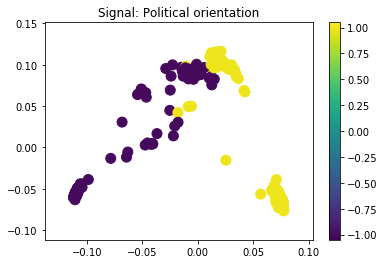

In [12]:
graph_pygsp = pg.graphs.Graph(adjacency)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(signal)
plt.title('Signal: Political orientation')

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

[-0.01, 1.2, 0, 13]

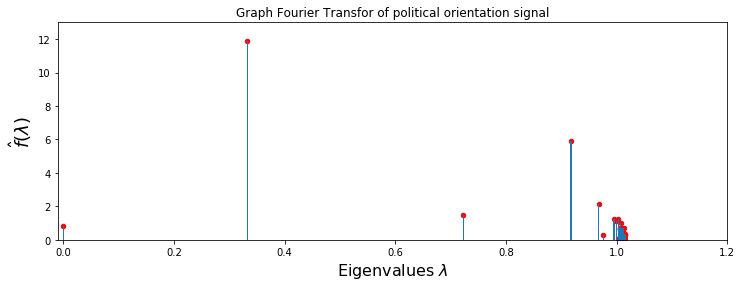

In [13]:
labels_F = abs(GFT(labels))

plt.figure(figsize=(12, 4))

plt.bar(e, labels_F, width=0.002)
plt.scatter(e, labels_F,s=20,color='red')
plt.xlabel('Eigenvalues $\lambda$', fontsize=16)
plt.ylabel('$\hat{f} (\lambda)$', fontsize=18)
plt.title('Graph Fourier Transfor of political orientation signal')
plt.axis([-0.01, 1.2, 0, 13])


### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Once tranformed into Fourier domain, we can see that our labels have a significant low pass component. At high frequencies (= eigenvalues) around the maximum frequency, the signal is strongly attenuated. Therefore, our signal is low pass, since most of the information seems to be contained in the five smallest frequencies.**

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [14]:
def heat_kernel(e, t):
    kernel=np.exp(-t*e)
    return kernel# Your code here.

def inverse_kernel(e, t):
    kernel=1/(1+t*e)
    return kernel# Your code here.

def rectangle_kernel(e, l_min, l_max):
    kernel=np.zeros(e.size)
    kernel[(e>l_min)&(e<l_max)]=1
    return kernel # Your code here.

def graph_filter(x, kernel,e, **kwargs):
    x_hat=GFT(x)
    filtred=kernel(e,**kwargs)*x_hat
    x_filtered=iGFT(filtred)
    return x_filtered

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

**Filter parameter choice: As could be seen in Question 4, the most information is contained in frequencies up to 0.95. Thus t should be chosen as 1/0.93 = 1.07. For the rectangle filter, we want to keep eigenvalues between 0.4 and 0.93**

Text(0.5, 0, 'Eigenvalues')

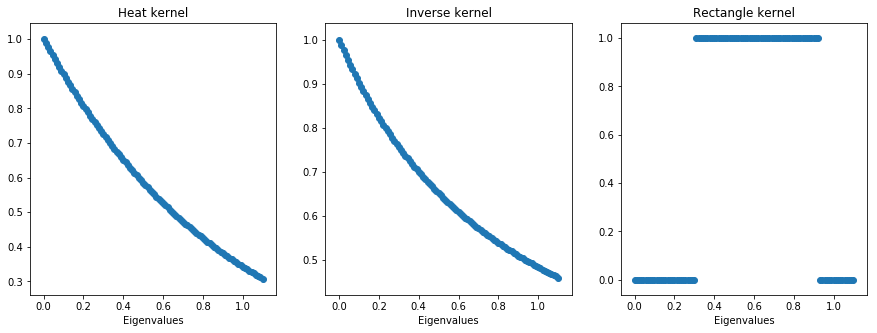

In [15]:
lamb = np.linspace(0,1.1,100)

fig1 = plt.figure(figsize=(15, 5))

ax1 = fig1.add_subplot(131)
plt.scatter(lamb,heat_kernel(lamb,1.07))
ax1.set_title('Heat kernel')
ax1.set_xlabel('Eigenvalues')

ax2 = fig1.add_subplot(132)
plt.scatter(lamb,inverse_kernel(lamb,1.07))
ax2.set_title('Inverse kernel')
ax2.set_xlabel('Eigenvalues')

ax = fig1.add_subplot(133)
plt.scatter(lamb,rectangle_kernel(lamb,0.3,0.93))
ax.set_title('Rectangle kernel')
ax.set_xlabel('Eigenvalues')

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

Text(0.5, 0.98, 'Inverse Kernel')

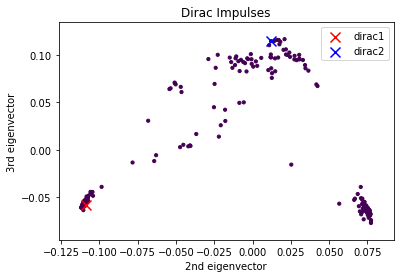

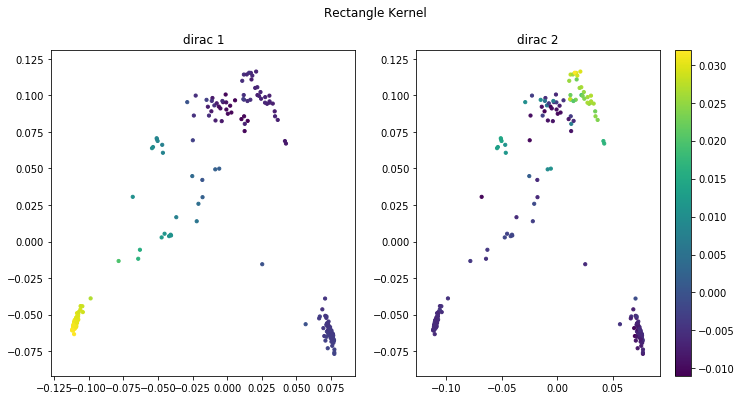

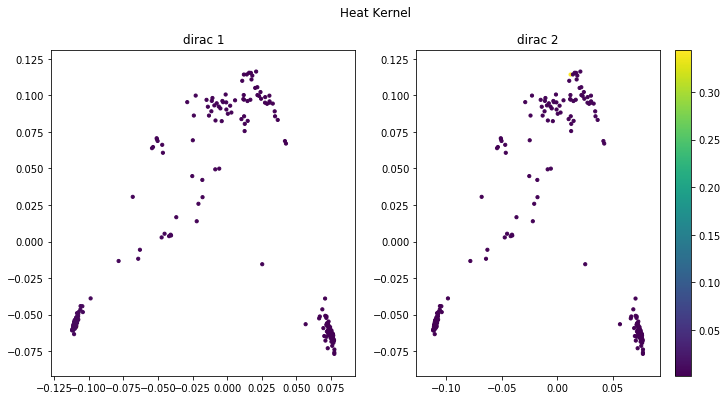

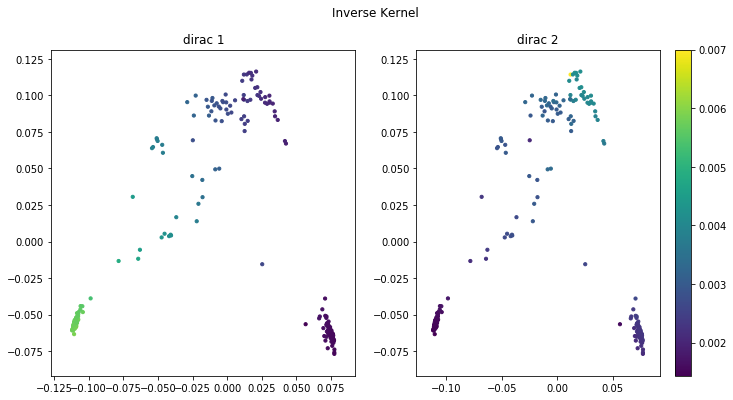

In [16]:
dirac_1=np.zeros(n_nodes)
dirac_1[20]=1
dirac_2=np.zeros(n_nodes)
dirac_2[50]=1

x=eigenvectors[:, 1]
y=eigenvectors[:, 2]# Laplacian eigenmaps.

plt.scatter(x,y,c=dirac_1,s=10)
plt.scatter(x[20],y[20],marker='x',s=100,c='red',label='dirac1')
plt.scatter(x[50],y[50],marker='x',s=100,c='blue',label='dirac2')
plt.title('Dirac Impulses')
plt.legend()
plt.xlabel('2nd eigenvector')
plt.ylabel('3rd eigenvector')


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
signal_1=graph_filter(dirac_1,rectangle_kernel,e,l_min=0.3,l_max=0.93)
signal_2=graph_filter(dirac_2,rectangle_kernel,e,l_min=0.3,l_max=0.93)
axs[0].scatter(x,y,c=signal_1,s=10)
axs[0].set_title('dirac 1')
imb=axs[1].scatter(x,y,c=signal_2,s=10)
axs[1].set_title('dirac 2')
fig.colorbar(imb)
fig.suptitle('Rectangle Kernel')

fig, axs = plt.subplots(1, 2,figsize=(12, 6))
signal_1=graph_filter(dirac_1,heat_kernel,e,t=1.07)
signal_2=graph_filter(dirac_2,heat_kernel,e,t=1.07)
axs[0].scatter(x,y,c=signal_1,s=10)
axs[0].set_title('dirac 1')
imb=axs[1].scatter(x,y,c=signal_2,s=10)
axs[1].set_title('dirac 2')
fig.colorbar(imb)
fig.suptitle('Heat Kernel')


fig, axs = plt.subplots(1, 2,figsize=(12, 6))
signal_1=graph_filter(dirac_1,inverse_kernel,e,t=1.07)
signal_2=graph_filter(dirac_2,inverse_kernel,e,t=1.07)
axs[0].scatter(x,y,c=signal_1,s=10,vmax=0.007)
axs[0].set_title('dirac 1')
imb=axs[1].scatter(x,y,c=signal_2,s=10,vmax=0.007)
axs[1].set_title('dirac 2')
fig.colorbar(imb)
fig.suptitle('Inverse Kernel')



Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**One sees the filtering reflects the clustering as information tends to diffuse faster to similar nodes. As our graph consists only of one component (multiplicity of null eigenvalue being one) and is fully connected, the information diffuses to all the nodes. However, depending on the origin of the impulse, the signal diffuses faster into right or left wing region**

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [17]:
Labels_var = np.var(labels)
noise_variance = Labels_var/1.5 
noisy_measurements = labels + np.sqrt(noise_variance) * np.random.randn(n_nodes)

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

**Since we are trying to minimize the above expression, the derivative at $z^\star$ is zero**

$$
||z-y||^2 + \gamma z^TLz = (z-y)^T(z-y) +  \gamma z^TLz \\
\frac{d}{dz}((z-y)^T(z-y) +  \gamma z^TLz) = 2((z-y)^T + \gamma z^T L) \\
2((z^\star-y) + \gamma  L z^\star) = 0 \\
z^\star = \frac{1}{I + \gamma L}y \\
z^\star = (I + \gamma L)^{−1} y \\
$$

**Which is the inverse filter, corresponding to a classical low-pass filter**


### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [18]:
z_heat_denoised =graph_filter(noisy_measurements,heat_kernel,e,t=1.07)
z_inv_denoised =graph_filter(noisy_measurements,inverse_kernel,e,t=1.07)
z_rect_denoised = graph_filter(noisy_measurements,rectangle_kernel,e,l_min=0.3,l_max=0.93)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

Text(0.5, 0.98, 'Filtering')

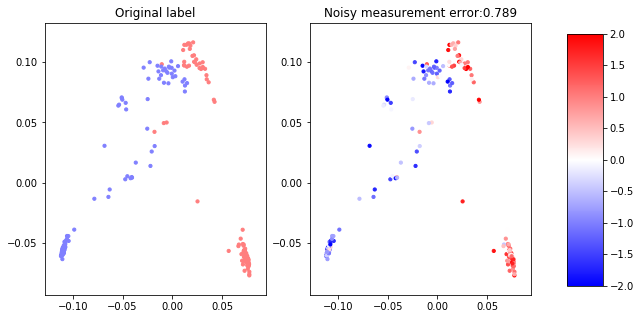

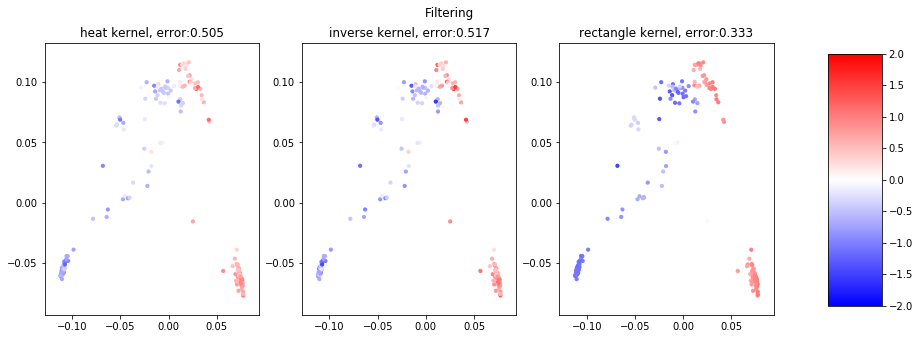

In [19]:
x=eigenvectors[:, 1]
y=eigenvectors[:, 2]# Laplacian eigenmaps.

error=np.linalg.norm(noisy_measurements-labels)/np.linalg.norm(labels)
error_heat=np.linalg.norm(z_heat_denoised-labels)/np.linalg.norm(labels)
error_inv=np.linalg.norm(z_inv_denoised-labels)/np.linalg.norm(labels)
error_rect=np.linalg.norm(z_rect_denoised-labels)/np.linalg.norm(labels)

fig, axs = plt.subplots(1, 2,figsize=(10,5))
im=axs[0].scatter(x,y,c=labels,s=10,vmin=-2,vmax=2,cmap=plt.get_cmap('bwr'))
axs[0].set_title('Original label')
axs[1].scatter(x,y,c=noisy_measurements,s=10,cmap=plt.get_cmap('bwr'),vmin=-2,vmax=2)
axs[1].set_title('Noisy measurement error:{0:.3f}'.format(error))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig, axs = plt.subplots(1, 3,figsize=(15, 5))

axs[0].scatter(x,y,c=z_heat_denoised,s=10,cmap=plt.get_cmap('bwr'),vmin=-2,vmax=2)
axs[0].set_title('heat kernel, error:{0:.3f}'.format(error_heat))
axs[1].scatter(x,y,c=z_inv_denoised,s=10,cmap=plt.get_cmap('bwr'),vmin=-2,vmax=2)
axs[1].set_title('inverse kernel, error:{0:.3f}'.format(error_inv))
im=axs[2].scatter(x,y,c=z_rect_denoised,s=10,cmap=plt.get_cmap('bwr'),vmin=-2,vmax=2)
axs[2].set_title('rectangle kernel, error:{0:.3f}'.format(error_rect))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Filtering')

Finally, overlay on the same plot the GFT of all five signals above.

Text(0.5, 0.98, 'signals GFT')

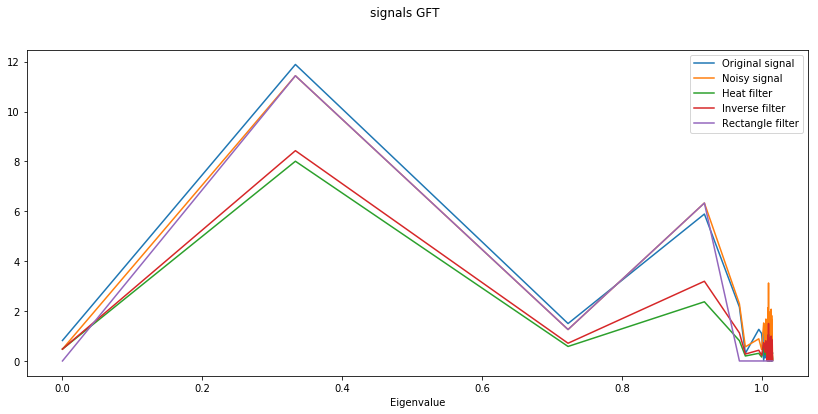

In [20]:
plt.figure(figsize=(14,6))
plt.plot(e,abs(GFT(labels)),label='Original signal')
plt.plot(e,abs(GFT(noisy_measurements)),label='Noisy signal')
plt.plot(e,abs(GFT(z_heat_denoised)),label='Heat filter')
plt.plot(e,abs(GFT(z_inv_denoised)),label='Inverse filter')
plt.plot(e,abs(GFT(z_rect_denoised)),label='Rectangle filter')
plt.legend()
plt.xlabel('Eigenvalue')
plt.suptitle('signals GFT')

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**The best filtering was achieved with the rectangle kernel. The underlying assumption is that the greater the weight of a link the more the nodes will have similar values. This is indeed verified by ou graph where clustering already shown the party ground truth could be computed from the adjacency matrix.**

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [21]:
# Our signal is already binary. The parties were already classified into right wing and left wing
labels_bin = labels

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [22]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.
# Set random seed
np.random.seed(0)
idx_chosen = np.random.permutation(n_nodes)[0:m]
w = np.zeros(n_nodes)
w[idx_chosen] = 1

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

C:\Users\silus\Anaconda3\envs\ntds_2018\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\silus\Anaconda3\envs\ntds_2018\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


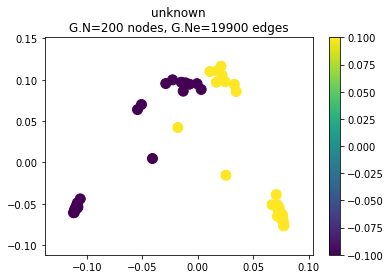

In [23]:
signal_subsample = labels_bin.astype(float)
signal_subsample[w == 0] = np.nan

graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(signal_subsample)

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [24]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [25]:
def P(a):
    b = np.zeros(len(a))
    for idx, val in enumerate(w):
        if val == 1:
            b[idx] = labels_bin[idx]
        else:
            b[idx] = a[idx]
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [26]:
# Make gradient scipy.sparse
gradient_sparse = sparse.csr_matrix(gradient)

sol_1norm_min = graph_pnorm_interpolation(gradient_sparse, P, x0=np.random.randn(n_nodes), p = 1.)

sol_2norm_min = graph_pnorm_interpolation(gradient_sparse, P, x0=np.random.randn(n_nodes), p = 2.)

threshold = 0

sol_1norm_bin = np.sign(sol_1norm_min - threshold*np.ones(len(sol_1norm_min)))

sol_2norm_bin = np.sign(sol_2norm_min - threshold*np.ones(len(sol_2norm_min)))

Solution found after 36 iterations:
    objective function f(sol) = 3.861820e+03
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 1.035582e+02
    stopping criterion: MAXIT


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

C:\Users\silus\Anaconda3\envs\ntds_2018\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\silus\Anaconda3\envs\ntds_2018\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


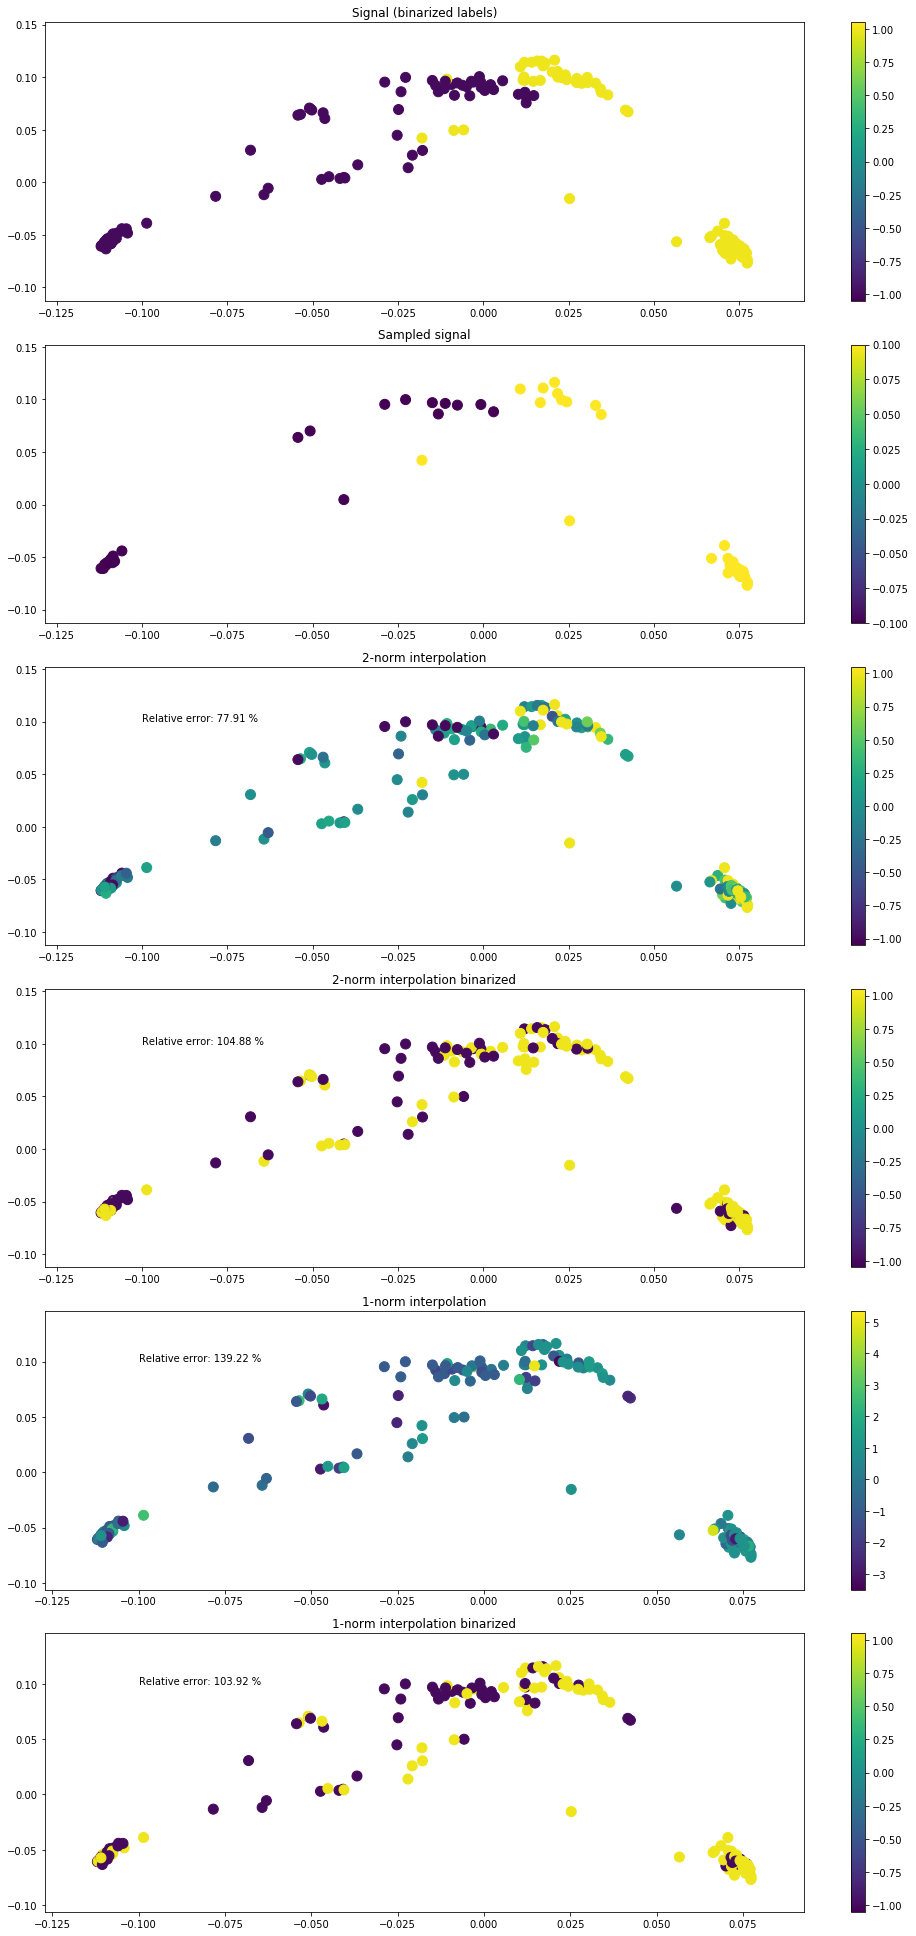

In [27]:
fig = plt.figure(figsize=(14,27))
# Original
ax1 = fig.add_subplot(611)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(labels_bin, ax=ax1)
ax1.set_title("Signal (binarized labels)")

# Original sampled
ax2 = fig.add_subplot(612)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(signal_subsample, ax=ax2)
ax2.set_title("Sampled signal")

# Solution 2-norm non-binary
ax3 = fig.add_subplot(613)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(sol_2norm_min, ax=ax3)
ax3.set_title("2-norm interpolation")
ax3.text(-0.1,0.1,"Relative error: {0:.2f} % ".format(100*np.linalg.norm(sol_2norm_min-labels_bin)/np.linalg.norm(labels_bin)))

# Solution 2-norm binary
ax4 = fig.add_subplot(614)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(sol_2norm_bin, ax=ax4)
ax4.set_title("2-norm interpolation binarized")
ax4.text(-0.1,0.1,"Relative error: {0:.2f} % ".format(100*np.linalg.norm(sol_2norm_bin-labels_bin)/np.linalg.norm(labels_bin)))
fig.tight_layout();

# Solution 2-norm non-binary
ax5 = fig.add_subplot(615)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(sol_1norm_min, ax=ax5)
ax5.set_title("1-norm interpolation")
ax5.text(-0.1,0.1,"Relative error: {0:.2f} % ".format(100*np.linalg.norm(sol_1norm_min-labels_bin)/np.linalg.norm(labels_bin)))

# Solution 2-norm binary
ax6 = fig.add_subplot(616)
graph_pygsp.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
graph_pygsp.plot_signal(sol_1norm_bin, ax=ax6)
ax6.set_title("1-norm interpolation binarized")
ax6.text(-0.1,0.1,"Relative error: {0:.2f} % ".format(100*np.linalg.norm(sol_1norm_bin-labels_bin)/np.linalg.norm(labels_bin)))
fig.tight_layout();

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [28]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):
    
    n_nodes = len(labels_bin)
    pt_matrix = np.zeros((len(thresholds), len(mn_ratios)))
    for r_idx, mn_r in enumerate(mn_ratios):
        m = int(mn_r * n_nodes)  # Number of measurements.
        idx_chosen = np.random.permutation(n_nodes)[0:m]
        w = np.zeros(n_nodes)
        w[idx_chosen] = 1
        
        # Interpolate n_trial times
        sol = np.zeros((n_trials, n_nodes))
        for n in range(n_trials):
            sol[n,:] = graph_pnorm_interpolation(gradient_sparse, P, x0=np.random.randn(n_nodes), p = p)
        
        # Compute relative error as a function of thresholds
        for idx, thres in enumerate(thresholds):
            sol_bin = np.sign(sol -  thres*np.ones((n_trials, n_nodes)))
            rel_error_node = np.linalg.norm(np.mean(sol_bin - labels_bin, axis=0))/np.linalg.norm(labels_bin)
            pt_matrix[idx, r_idx] = rel_error_node

    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [29]:
mn_ratios = np.linspace(0,1,5)
n_trials = 20
thresholds = np.linspace(-1,1,5)

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, 1)

pt_matrix_2norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, 1)

Solution found after 36 iterations:
    objective function f(sol) = 4.012101e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.811417e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.020728e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.290978e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.222053e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.008304e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.690956e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.272630e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.583254e+03
    stopping criterion: RTOL
Solution f

Solution found after 36 iterations:
    objective function f(sol) = 3.887871e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.822451e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.844117e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.209040e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.326383e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.241833e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.859362e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.014970e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.184851e+03
    stopping criterion: RTOL
Solution f

Solution found after 36 iterations:
    objective function f(sol) = 3.938650e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.023231e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.890260e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.947652e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.478069e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.025440e+03
    stopping criterion: RTOL
Solution found after 62 iterations:
    objective function f(sol) = 1.880516e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 3.967860e+03
    stopping criterion: RTOL
Solution found after 36 iterations:
    objective function f(sol) = 4.163546e+03
    stopping criterion: RTOL
Solution f

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

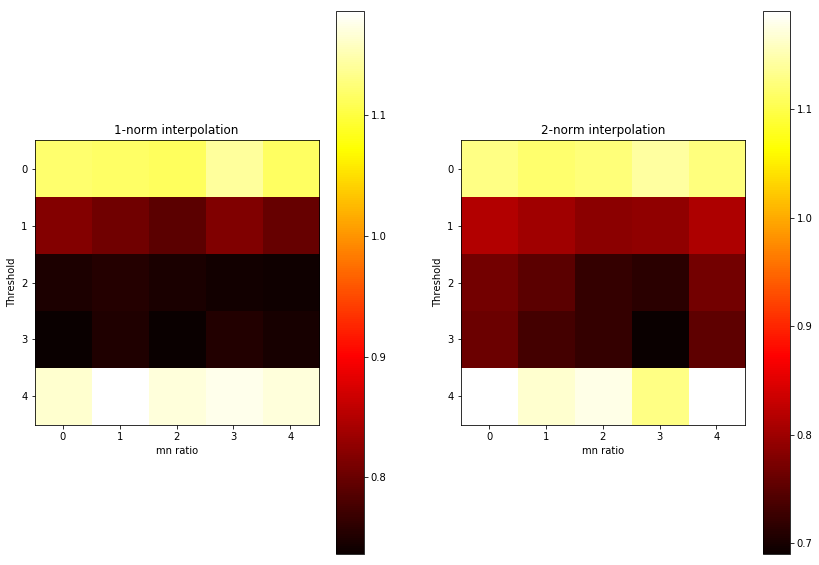

In [30]:
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.imshow(pt_matrix_1norm, cmap='hot')
plt.title('1-norm interpolation')
plt.xlabel('mn ratio')
plt.ylabel('Threshold')
plt.colorbar()
plt.subplot(122)
plt.imshow(pt_matrix_2norm, cmap='hot')
plt.title('2-norm interpolation')
plt.xlabel('mn ratio')
plt.ylabel('Threshold')
plt.colorbar()

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**The difference that we can observe between the two norms are not very significant. Overall it seems that for thresholds around zero, the p1 norm performs slightly better for most mn ratios. Both norms work best with thresholds around 0. It does not seem to be possible to say that one norm definitely performs better than the other. Nevertheless, for both norms,the relative error is too high to really say that the learned signal z approximates the real signal**